In [13]:
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
# Set paths
DATASET_PATH = "Deforestation_Data/train/"
MASKS_PATH = "Deforestation_Data/Masks/"
IMG_SIZE = (128, 128)

# Function to load images and masks
def load_images_and_masks(image_folder, mask_folder):
    images, masks = [], []
    for file in os.listdir(image_folder):
        img_path = os.path.join(image_folder, file)
        mask_path = os.path.join(mask_folder, file)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalize
            mask = load_img(mask_path, target_size=IMG_SIZE, color_mode="grayscale")
            mask_array = img_to_array(mask) / 255.0  # Normalize to [0,1]
            images.append(img_array)
            masks.append(mask_array)
        except:
            print(f"Skipping corrupted image: {file}")
    return np.array(images), np.array(masks)

# Load training data
deforestation_images, deforestation_masks = load_images_and_masks(
    os.path.join(DATASET_PATH, "Deforestation"), os.path.join(MASKS_PATH, "Deforestation")
)
normal_images, normal_masks = load_images_and_masks(
    os.path.join(DATASET_PATH, "Normal"), os.path.join(MASKS_PATH, "Normal")
)

Skipping corrupted image: -73.15884,46.38819.jpg
Skipping corrupted image: -75.05573,54.09413.jpg
Skipping corrupted image: -76.18264,50.14719.jpg
Skipping corrupted image: -76.18516,52.38909.jpg
Skipping corrupted image: -76.18557,45.74491.jpg
Skipping corrupted image: -76.18621,49.56655.jpg
Skipping corrupted image: -77.71163,54.13459.jpg
Skipping corrupted image: -77.71524,49.70264.jpg
Skipping corrupted image: -77.72166,48.20714.jpg
Skipping corrupted image: -77.72477,55.23142.jpg
Skipping corrupted image: -77.7259,50.61841.jpg
Skipping corrupted image: -77.7422,46.1992.jpg
Skipping corrupted image: -77.74319,48.67836.jpg
Skipping corrupted image: -77.7564,46.4861.jpg
Skipping corrupted image: -77.76373,47.78867.jpg
Skipping corrupted image: -77.77004,48.10492.jpg
Skipping corrupted image: -77.77127,47.07824.jpg
Skipping corrupted image: -77.77528,49.41337.jpg
Skipping corrupted image: -77.7772,46.5056.jpg
Skipping corrupted image: -77.784,47.58513.jpg
Skipping corrupted image: -77

In [14]:
# Combine datasets
X = np.concatenate([deforestation_images, normal_images], axis=0)
y = np.concatenate([deforestation_masks, normal_masks], axis=0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape}, Testing Samples: {X_test.shape}")

Training Samples: (4628, 128, 128, 3), Testing Samples: (1157, 128, 128, 3)


In [17]:
# U-Net Model
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u1 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [19]:
 #Initialize and train model
unet = unet_model()
unet.fit(X_train, y_train, epochs=1, batch_size=8, validation_data=(X_test, y_test))

579/579 ━━━━━━━━━━━━━━━━━━━━ 1168s 2s/step - accuracy: 0.5832 - loss: 0.6470 - val_accuracy: 0.5819 - val_loss: 0.6381


In [21]:
# Save model
unet.save("unet_deforestation.h5")

# Load model
def load_trained_model():
    return tf.keras.models.load_model("unet_deforestation.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


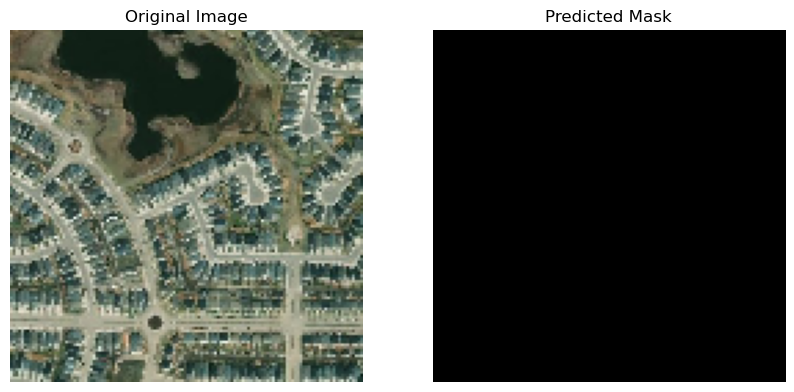

In [27]:
# Predict on test image
def predict_deforestation(image_path, model):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred_mask = model.predict(img_array)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.show()

# Run prediction
test_model = load_trained_model()
test_image_path = "Deforestation_Data/train/Deforestation/-113.91782,50.896917.jpg"
predict_deforestation(test_image_path, test_model)
